### IMDB Dataset of 50K Movie Reviews to perform Sentiment analysis

### Specific Objective: Test and train various models to classify sentiment as either positive or negative for a given movie review

To accomplish our objective, I will test out various models that are generally used for binary classification problems and compare the initial performance. I will attempt to improve each of the models and ultimately select the model that does best after this for further optimiztaion.

I chose 3 models for this task, one from each bucket of “complexity”. While there are many other models suitable for binary classification, in my experience it’s best to start with a few and then add more if the accuracy is not there. In this case, since the task is relatively straightforward, I decided to try 3, but pick them based on how complex and explainable they are. The simplest model was Logistic Regression. Logistic Regression is one of the simplest classifiers and it’s decisions can be easily interpreted and understood, an important aspect in some projects when you not only need to get the model to work but also be able to explain it’s inner-workings to stakeholders such as managers and clients.  The second model I chose was Gradient Boosted Trees via XGBoost, which falls into a medium complexity bucket. XGBoost is a well-established and effective algorithm that uses gradient boosting frameworks. It's particularly useful due to its flexibility and high performance, especially with datasets where relationships may not be linear, a possible scenario in our case. It's more complex than Logistic Regression, but it provides a good balance between performance and interpretability. You can visualize the trees and feature importances, helping to understand which features are driving predictions.

Lastly, I picked a Sequential Neural Network, the most complex model out of the three. Neural networks are a form of deep learning and are exceptionally effective at learning from unstructured data, such as text data in our IMDB dataset. They can model intricate patterns and nonlinear relationships, which can lead to higher accuracy. However, the trade-off is that they are often referred to as "black boxes" due to their lack of interpretability. Understanding the inner workings of a deep neural network is challenging, which might not always be suitable, especially in scenarios where model explain ability is crucial. But in cases where the highest accuracy is the main goal, neural networks often come out on top.

The goal of choosing these three models was to explore the trade-off between model complexity, performance, and interpretability, giving us a broader understanding of what can be achieved with different approaches for this binary classification task on the IMDB dataset.


<b>Model Descriptions:</b>
- <b>Logistic Regression:</b> Logistic Regression is a linear model that is widely used for binary classification. It is simple to implement, computationally efficient, and easy to interpret. It models the probability of the target class using a sigmoid function. <br>
- <b>Gradient Boosted Trees:</b> Gradient Boosted Trees (GBTs) are also an ensemble learning method that combines multiple decision trees. However, unlike random forests, GBTs add trees sequentially, with each tree correcting the errors of the previous one. <br>
- <b>Neural Networks:</b> Neural networks are a powerful class of models that can learn complex non-linear relationships between features. They have shown state-of-the-art performance on many classification tasks in recent years.<br>
    
I will implement 3 of these models: Logistic Regression, Gradient Boosted Tree, and a Neural Net and compare the performance

<b>Data Prep</b><br>
- TD-IDF vectorization with SelectKBest algorithm to select the most important features
- Applied arbitrary selection of 2k best features out of 743k features (~2.7%) using SelectKBest feature selection algorithm
- Reasons for reducing number of features:
    - Dimensionality reduction: By selecting a subset of the most informative features, we can reduce the dimensionality of the data and potentially improve computational efficiency, reduce memory requirements, and try to alleviate the "curse of dimensionality".
    - Noise reduction: If a large proportion of the features are noisy, redundant, or uninformative, selecting the top features can help filter out the noise and improve the model's ability to learn relevant patterns and make accurate predictions.
    - Improved interpretability: Working with a smaller subset of features can enhance model interpretability by focusing on the most important factors influencing the task.

<b>NOTE:</b> Before running this notebook, make sure you:
- Download the IMDB Dataset to the working directory. You can download the dataset here: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Download the pre-trained word embeddings using the code below

In [1]:
# Notebook-level Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
# Set default font size
plt.rcParams.update({'font.size': 20})

In [17]:
# utility function to extract the saved model
import os
import typing as T
import pickle
from tensorflow import keras

def load_model(path: str) -> T.Any:
    """Unpickles an object at the given path"""
    with open(path, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

def save_model(filename: str, model: T.Any):
    """Serializes model and saves as a file"""
    # store the model parameters in a file
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [4]:
### Load Data
data = pd.read_csv('IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
# review the data and apply some pre-processing
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Number of poitive and negative reviews - looks like the data is balanced
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [33]:
# transform positive and negative to 0s and 1s for more ease
# Lets encode labels: each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


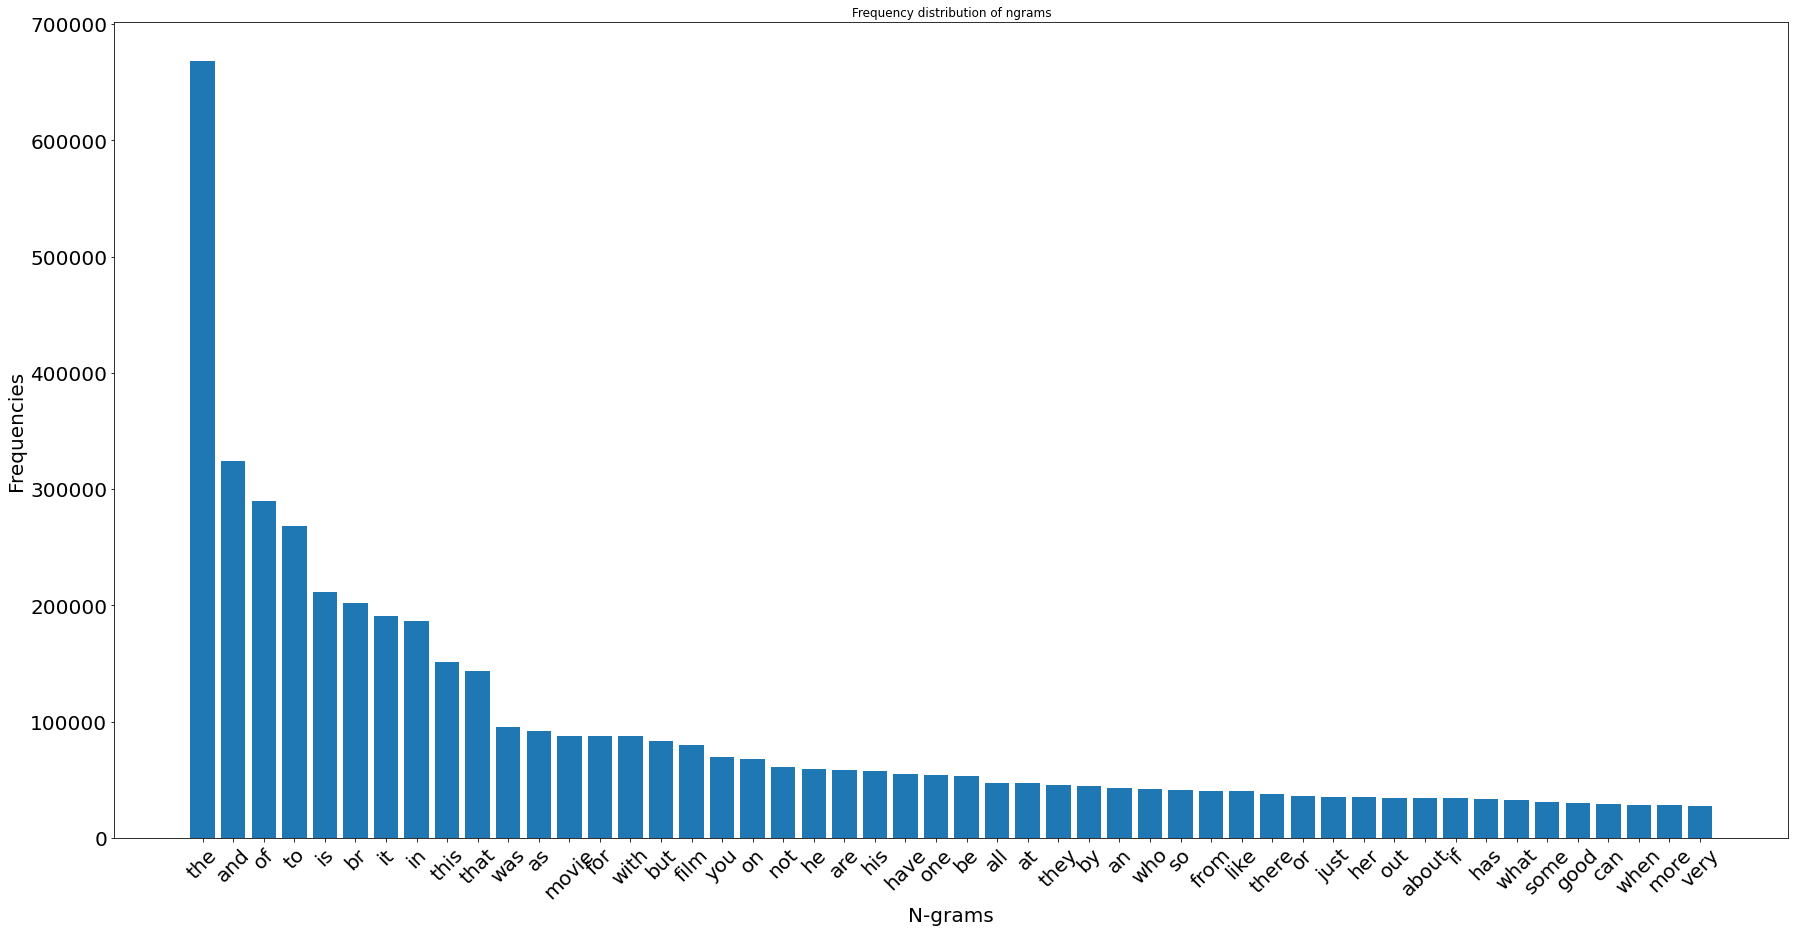

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(data['review']))
all_ngrams = vectorizer.get_feature_names_out()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 15))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams', fontsize=20)
plt.ylabel('Frequencies', fontsize=20)
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [46]:
# get rid of stop words (i.e. words that occur freequently in all documents and add little signal)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Get the total number of features before feature selection
    num_features_before_selection = transformed_texts.shape[1]
    print("Total number of features before feature selection:", num_features_before_selection)

    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    
    # Get the total number of features after feature selection
    num_features_after_selection = transformed_texts.shape[1]
    print("Total number of features after feature selection:", num_features_after_selection)
    
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(data['review'], data['sentiment'])

/Users/richardgoldman/opt/anaconda3/envs/deep_learning_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Total number of features before feature selection: 743933
Total number of features after feature selection: 20000


In [36]:
# check out the size of our resulting feature vector
vect_data.shape

(50000, 20000)

In [37]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(data['review'])
tr_texts.shape

(50000, 101895)

In [38]:
from sklearn.model_selection import train_test_split

# Split data to target (y) and features (X)
X = vect_data.toarray()
y = (np.array(data['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


### Logistic Regression

Training Accuracy: 0.911825
Testing Accuracy: 0.8984


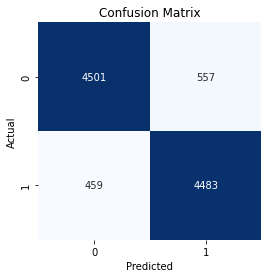

Precision: 0.8894841269841269
Recall: 0.9071226224200728
F1 Score:  0.898401792229807


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_SAVE_PATH = 'logreg.pkl'
# create a logistic regression model and fit it to the training data
try:
    logreg = load_model(MODEL_SAVE_PATH)
except FileNotFoundError:
    print("Saved model not found, re-training model")
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

# Evaluate the model on the training data
train_score = logreg.score(X_train, y_train)
print(f"Training Accuracy: {train_score}")

# Evaluate the model on the testing data
test_score = logreg.score(X_test, y_test)
print(f"Testing Accuracy: {test_score}")

# Predict on test data and get f1-score
y_pred = logreg.predict(X_test)
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_score = classification_report_dict['weighted avg']['f1-score']

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get precision and recall
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Print precision and recall
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score: ', f1_score)

# save model
# save_model('logreg.pkl', logreg)

### Gradient Boosted Decision Trees 

In [40]:
## XGBoost
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

try:
    xgb_model = load_model('xgb_model.pkl')
except FileNotFoundError:
    print("Saved model not found, re-training model")
    xgb_model = xgb.XGBClassifier(n_jobs=14)
    xgb_model.fit(X_train, y_train)

# Predict labels for test data
y_pred = xgb_model.predict(X_test)

# Evaluate model performance on test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Predict labels for training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate model performance on training data
accuracy_train = accuracy_score(y_train, y_train_pred)

# Print evaluation metrics
print('Training Accuracy:', accuracy_train)
print('Testing Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

# save model
save_model('xgboost.pkl', xgb_model)

Training Accuracy: 0.9387
Testing Accuracy: 0.8655
Precision: 0.854244632657081
Recall: 0.877579927154998


<b>Notes</b><br>The XGBoost model took about an hour to train and it does worse than the simple logistic regression model.

### Neural Network
In order to create the neural net, I needed to decide on an initial answer to the following questions:

1. *How many layers to use in the model?*
2. *How many hidden units to use for each layer?*
3. *Choice of activation function (ReLU, Sigmoid, Tanh, etc.)

In this example, the input data consists of an array of word-probabilities. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [16]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
    
    
try:
    nnet = load_model('neural_net.pkl')
except FileNotFoundError:
    print("Saved model not found, re-training model")
    DROPOUT_RATE = 0.2
    UNITS = 64
    NUM_CLASSES = 2
    LAYERS = 2
    input_shape = X_train.shape[1:]

    op_units, op_activation = 1, 'sigmoid'

    nnet = keras.Sequential()
    # Applies Dropout to the input
    nnet.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
    for _ in range(LAYERS-1):
        nnet.add(Dense(units=UNITS, activation='relu'))
        nnet.add(Dropout(rate=DROPOUT_RATE))

    nnet.add(Dense(units=op_units, activation=op_activation))

    # compile the model
    nnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # print model summary
    nnet.summary()

    EPOCHS = 100
    BATCH_SIZE = 128

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

    # Train and validate model
    # To start training, call the model.fit method—the model is "fit" to the training data.
    # Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
    history = nnet.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

# predict on test data
y_pred = nnet.predict(X_test)
    
# save model
# save_model('neural_net.pkl', nnet)

# Evaluate the model on the train dataset
train_loss, train_acc = nnet.evaluate(X_train, y_train, verbose=1)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

# Next, compare how the model performs on the test dataset:
test_loss, test_acc = nnet.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0695 - accuracy: 0.9804
Train loss: 0.06948278099298477
Train accuracy: 0.9804499745368958
313/313 [==============================] - 1s 2ms/step - loss: 0.1799 - accuracy: 0.9322
Test loss: 0.1798858493566513
Test accuracy: 0.932200014591217


Model Compilation Notes
* **Loss function** — Selecting binary crossentropy since this is a binary classification problem
* **Optimizer** — Selected Adam since it is well-suited for large datasets like the IMDb dataset and has been shown to work well for a wide range of deep learning tasks, including natural language processing. It combines advantages from AdaGrad and RMSProp which allow it to dynamically adjust the learning rate during training to prevent it from getting stuck in a local miniumum.

* **Metrics** — want to look at accuracy, F1 and AUC 

### Let's see if we can improve model performance by using pre-trained word embeddings (PTWE)

In [18]:
# Download the pre-trained word embeddings - ONLY RUN THIS IF THE EMBEDDINGS FILE IS NOT ALREADY STORED
# import urllib.request
# import os
# url = 'http://nlp.stanford.edu/data/glove.6B.zip'
# filename = 'glove.6B.zip'
# if not os.path.exists(filename):
#     urllib.request.urlretrieve(url, filename)
# # Extract the contents of the zip file
# import zipfile
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()

In [41]:
# Load the pre-trained word embeddings
from gensim.models import KeyedVectors

model_path = 'glove.6B.100d.txt'
word_vectors = KeyedVectors.load_word2vec_format(model_path, no_header=True, binary=False)

# print the size of the vocabulary and the dimensionality of the word vectors
print('Vocabulary size:', len(word_vectors.key_to_index))
print('Dimensionality of word vectors:', word_vectors.vector_size)

Vocabulary size: 400000
Dimensionality of word vectors: 100


In [42]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# get train test of data from pre-trained embeddings
# Define tokenizer function that converts text to list of word vectors
def tokenize(text):
    tokens = []
    for word in text.split():
        try:
            vector = word_vectors[word]
            tokens.append(tuple(vector))  # Convert numpy array to a hashable that can be used in fit_transform
        except KeyError:
            pass
    return tokens

# Define vectorizer that uses the tokenizer function
vectorizer = TfidfVectorizer(tokenizer=tokenize, preprocessor=None, lowercase=False)

# Vectorize the data
vect_data = vectorizer.fit_transform(data['review'])

# Select best k features, with feature importance measured by f_classif
TOP_K = 20000
selector = SelectKBest(f_classif, k=min(TOP_K, vect_data.shape[1]))
selector.fit(vect_data, data['sentiment'])
vect_data = selector.transform(vect_data).astype('float32')

# Split data to target (y) and features (X)
X = vect_data.toarray()
y = np.array(data['sentiment'])

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

/Users/richardgoldman/opt/anaconda3/envs/deep_learning_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training Accuracy: 0.8965
Testing Accuracy: 0.8744


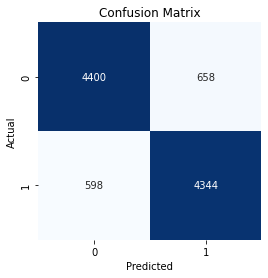

f1-score 0.8744042202923483
Precision: 0.868452618952419
Recall: 0.8789963577498988


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create logistic regression model and fit it to the training data
try:
    logreg = load_model('logreg_ptwe.pkl')
except FileNotFoundError:
    print("Saved model not found, re-training model")
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

# Evaluate the model on the training data
train_score = logreg.score(X_train, y_train)
print(f"Training Accuracy: {train_score}")

# Evaluate the model on the testing data
test_score = logreg.score(X_test, y_test)
print(f"Testing Accuracy: {test_score}")

# Predict on test data and get f1-score
y_pred = logreg.predict(X_test)
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_score = classification_report_dict['weighted avg']['f1-score']

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get precision and recall
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Print precision and recall
print('f1-score', f1_score)
print('Precision:', precision)
print('Recall:', recall)
# print(classification_report_dict) # for reference

# save model
save_model('logreg_ptwe.pkl', logreg)

<b> Analysis of Logistic Regression with pre-trained embeddings </b>
Comparing the original logistic regression model to this model, we can see that this model actually performed worse across the board: <br>
- Worse Validation Accuracy (84% vs. 90%)
- Worse F1-Score (Recall 86% vs. 91% and Precision 83% vs. 89%)
    
This is an interesting and unexpected result. Based on the validation vs. train performance metrics, the model does not seem to be overfitting significantly to the training set, so more investigation would be needed to figure out why this is not offering any improvement to the original model

In [44]:
## XGBoost
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score

try:
    xgb_model_w_ptwe = load_model('xgboost_ptwe.pkl')
except FileNotFoundError:
    print("Saved model not found, re-training model")
    xgb_model_w_ptwe = xgb.XGBClassifier(n_jobs=14)
    xgb_model_w_ptwe.fit(X_train, y_train)
    
# Predict labels for test data
y_pred = xgb_model_w_ptwe.predict(X_test)

# Evaluate model performance on test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Predict labels for training data
y_train_pred = xgb_model_w_ptwe.predict(X_train)

# Evaluate model performance on training data
accuracy_train = accuracy_score(y_train, y_train_pred)

# Print evaluation metrics
print('Training Accuracy:', accuracy_train)
print('Testing Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

# save model
# save_model('xgboost_ptwe.pkl', xgb_model_w_ptwe)

Training Accuracy: 0.916375
Testing Accuracy: 0.8396
Precision: 0.8250876509544215
Recall: 0.8571428571428571


In [45]:
# lastly, try using the neural net with pre-trained embeddings
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


try:
    nnet_ptwe = load_model('neural_net_ptwe.pkl')
except FileNotFoundError:
    print("Saved model not found, re-training model")
    DROPOUT_RATE = 0.2
    UNITS = 64
    NUM_CLASSES = 2
    LAYERS = 2
    input_shape = X_train.shape[1:]

    op_units, op_activation = 1, 'sigmoid'

    nnet_ptwe = keras.Sequential()
    # Applies Dropout to the input
    nnet_ptwe.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
    for _ in range(LAYERS-1):
        nnet_ptwe.add(Dense(units=UNITS, activation='relu'))
        nnet_ptwe.add(Dropout(rate=DROPOUT_RATE))

    nnet_ptwe.add(Dense(units=op_units, activation=op_activation))

    # compile the model
    LEARNING_RATE = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    nnet_ptwe.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    EPOCHS = 100
    BATCH_SIZE = 128

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    history = nnet_ptwe.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

    # predict on test data
    y_pred = nnet_ptwe.predict(X_test)
    
# compare how the model performs on the test dataset:
train_loss, train_acc = nnet_ptwe.evaluate(X_train, y_train, verbose=1)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)
test_loss, test_acc = nnet_ptwe.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# save model
# save_model('neural_net_ptwe.pkl', nnet_ptwe)

1250/1250 [==============================] - 3s 2ms/step - loss: 2.0425 - acc: 0.4593
Train loss: 2.0424845218658447
Train accuracy: 0.4593000113964081
313/313 [==============================] - 1s 2ms/step - loss: 2.0454 - acc: 0.4561
Test loss: 2.045423984527588
Test accuracy: 0.4560999870300293


### Discussion of Results

<b>Reviewing the datset:</b>
The IMDB dataset has 50k samples and is balaned evenly between positive and negative samples so dataset imbalances was not a concern in this project. This balance was reflected in the general equality between precision and recall indicated in the confusion matrices. 

<b>Comparison of performance metrics for each model:<b>
- Comparison of initial model Train Accuracy and Test Accuracy to models trained using pre-trained word embeddings(PTWE)
    - Logistic Regression: 
        - Original: train (0.91) test (0.90)
        - PTWE: train (0.90) test (0.87)
    - Gradient Boosted Trees via XGBoost:
        - Original: train (0.94) test (0.87)
        - PTWE: train (0.92) test (0.84)
    - Sequential Neural Net: 
        - Original: train (0.98) test (0.93)
        - PTWE: train (0.96) test (0.90)

<b>Discussion of Logistic Regression and Potential Improvements:</b>
The Original Logistic Regression performed better than the PTWE model, which seemed to be slightly overfitting on the training data. A better understanding of using PTWE would be necessary to figure out how to get the Logistic Regression model to work better than the initial if this is even possible.

<b>Discussion of Gradient Boosted Trees via XGBoost and Potential Improvements:</b>
Gradient Boosted Trees seemed to be a poor model out-of-the-box for this problem. In both cases, the XGBoost model overfit rather severly to the training data as evidenced by the disparity >5% between train and test datasets. Potential improvements to explore for this model would be to experiment with the regularization parameters to reduce overfitting. In addition, since XGBoost is highly sensitive to hyperparameters, it would be important to experiment with a range of different hyperparameters to make sure that the model can perform at its best. This is especially important for xgboost in comparison with logistc regression which has fewer hyperparameters to tune and is less complex in general.
    
<b>Discussion of Simple Sequential Neural Net and Potential Improvements:</b>
Neural net performaed significantly better than both logistic regression and gradient boosted trees with 93% accuracy for the simple version with no optimizations. This is definitely the most promising model in terms of performance, and training time was only about ~1 minute. In both the original and PTWE, overfitting was an issue, and more dropout would likely be the first thing to try. It might also be good to add some regularization. If accuracy is the desired goal, and explainability/complexity is less of a concern, than the neural net is a clear winner for this task.
    
    
<b>Failure of using PTWE to improve model performance:</b>
This was a rather surprising failure since pre-trained word embeddings are supposed to allow models to better generalize since they have access to "out-of-vocabulary" words. More investigation would be necessary to understand why pre-trained embeddings are not adding to model performance on the IMDB datset.   

<b>Conclusion:</b> <br>
- Best model in terms of time to train, performance, and explainability:
    - Logistic Regression would be my recomendation for solving this binary classification problem if the given level of accuracy (~90%) is acceptable. The Logistic Regression model is explainable since we can clearly identify how the inputs, coefficients, and model are affecting the output. There are many tools for assesing this, and it's much simpler to determine how the model is working than with the neural net or the gradient-boosted tree model.
    - If 90% is not acceptable and extremely high levels of accuracy (>99%) are required, then I would recommend pursuing the neural network since there are more avenues for potential improvement and the degree of sophistication and complexity can be scaled up more easily than with Logistic Regression which is a very simple model.
   